<a href="https://colab.research.google.com/github/zeon-kun/AO3-Wrapped/blob/main/AO3Wrapped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to AO3 Wrapped!
This is a simple code that I made quickly just to get a little idea on what a Wrapped would look like.


## How it works:
**To make it short, there are 3 steps you need to do:**

1 - Type your credentials in the first code cell

2 - Run the first code cell

3 - Run the next code cell (the very long one).

**It will only work if you do these 3 things.**


You only have to click on the "play" button on the top left of the code cell to run it (or, Ctrl + Enter on the cell): 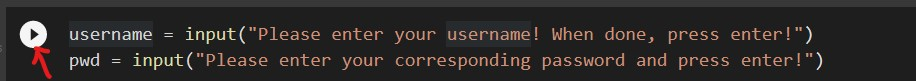


## About logging into your account
This script is only going to get the html data of your AO3 history and compute a summary of it. In order to do that, the code needs to send a request to AO3 to log into your account; you have to enter your username (not mail address) and password when asked bellow. Please fill the code cell bellow like this:

```
username ="MyAo3username" 
```
Do not put spaces, respect the cases, DO NOT delete the quotation marks.

**Privacy**: This is *your own notebook*, no one else has access to the modifications/inputs you're entering here. You can modify the code however you want, I don't have access to your version! None of the data entered here are to be kept even by google; the kernel is wiped out every time you close the browser. :)

So, here we go!

# **Step 1 and 2 :** Write your credentials bellow, then run the cell:

In [3]:
username ="nathanslee" #Please enter your username in between the quotation marks. DO NOT remove the quotation marks!
pwd = "Laksita19"  ##Do the same with your password, then run the cell

username = username.replace(' ','')
pwd = pwd.replace(' ','')

##installing non default library and fetching the blank pictures to fill
!pip install mechanize
!git clone https://github.com/soupbanana/AO3_wrapped.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'AO3_wrapped' already exists and is not an empty directory.


All set!

Now, you will run the actual code. It might take some time to finish, especially if there are a lot of pages to open. If everything goes smoothly, the first resulting picture will be dislayed at the very end of the cell! When done, a little check mark appears close to the "play" mark of the cell:
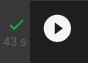

All the resulting png pictures (1.png, 2.png, 3.png, 4.png) will be saved on the folder of the workspace,

<- here 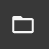

So when it's done, you can simply download them! They will be deleted when you close the workspace, or when it disconnect after a while.

If the code stops in the middle and some error message appear, there was a bug somewhere, and I'm very sorry about that TT

### **Please note :** 

*   After 10 pages of history browsed, the AO3 server gets overwhelmed, so the program pauses for 120sec before continuing. It's normal if it takes a long time if you have a lot of pages in your history! As long as you don't get an error, the code is still running.
*   You can follow the progress of the code at the very end of the page, bellow the long code cell.
*  If you try to run the first cell with your credentials more than once, you might get an error saying that "the AO3 wrapped folder is not empty" or something like that. It's because the files were already fetched, so you should be able to proceed with the next step nonetheless!
*   If your are on a phone, the resulting pics should be found in the menu on the left, in **"Show file browser"**.
*   **IF YOU GET AN ERROR WHILE RUNNING THE SECOND CELL** - try changing your password, it solved the error for the few people who got it.


### **Disclaimer**: 
* All this is only based on your history, meaning that it can take into account fics you haven't actualy read, but simply visited (except for the ones in marked for later, that are ignored). Sorry in advance if you notice some wrong results :')
* I'm not a developper at all, so there might be things I forgot to take into account, very sorry if it doesn't work for you :') I don't think I will be maintening the script, but you can try telling me about bugs on twitter if you want.
* If you are a developper and realize my code is very not optimal don't come at meeee
* I'm not a graphic designer either, sorry if the results look clapped lmao

# **Final step**: Run the cell bellow: 

In [4]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import mechanize
import re
from PIL import Image
import numpy as np
from collections import Counter
import IPython.display as Idisplay
import io
from PIL import ImageDraw, ImageFont
import time
import string


def openLink(link, user, pwd):
  isOpen = False
  while not isOpen:
    try:
      br = mechanize.Browser()
      br.open(link)

      br.select_form(id = "new_user_session_small") 
      br["user[login]"] = user
      br["user[password]"] = pwd

      response = br.submit()
      isOpen = True
    except:
      print("Too many request, waiting for a bit and retry it...")
      time.sleep(120)
    
  myfile = response.get_data()

  br.close()
  time.sleep(2)

  return myfile

### DATA COLLECTION - scrapping your readings -----------------------
wrapped_year = '2022'

titles = []
authors = []
ships = []
characters = []
ratings = []
fandoms = []
tags = []
words = []

user = 0
isDone = False
#open first page
p = 1
link = "https://archiveofourown.org/users/" + username + "/readings"

myfile = openLink(link, username, pwd)

soup = BeautifulSoup(myfile, 'html.parser')
nav = soup.find("ol", attrs={"role":"navigation"})
pages = nav.findAll("a")
last_page = int(pages[-2].text)

# #looping through the history pages
while not isDone or p <= last_page:
# for n in range(2):
  fics = soup.findAll('div', attrs={'class':"header module"})
  extras = soup.findAll('ul', attrs={'class':"tags commas"})
  stats = soup.findAll('dl', attrs={'class':"stats"})
  views = soup.findAll('h4', attrs={'class':"viewed heading"})

  for fic in range(len(fics)):
    v = fics[fic]
    s = stats[fic]
    e = extras[fic]

    ## get year of visit 
    year = views[fic].text[22:26]
    mfl = "Marked for Later" in views[fic].text

    if year == '2021': #if last visit older than 2022, stop loop
      isDone = True
    elif mfl:
      pass ## ignore if in mark for later

    else:
      heading = v.find('h4', attrs={'class':'heading'})
      title = heading.find(href=re.compile("works")).text
      author = heading.find('a', attrs={'rel':'author'})
      if author is None:
        author = ['Anonymous']
      else:
        author = author.text.replace('(','').replace(')', '').split(' ')
      fandom = [f.text for f in v.findAll('a', attrs={'class':"tag"})]
      rating = [v.findAll('a', attrs={'class':"help symbol question modal"})[0].text]

      relationship = [f.text for f in e.findAll('li' , attrs={'class':"relationships"})]
      character = [f.text for f in e.findAll('li' , attrs={'class':"characters"})]
      tag = [f.text for f in e.findAll('li' , attrs={'class':"freeforms"})]

      word = s.find('dd', attrs={'class':"words"}).text
      word = int(word.replace(',',""))

      titles.append(title)
      authors.append(author)
      ships.append(relationship)
      characters.append(character)
      ratings.append(rating)
      fandoms.append(fandom)
      tags.append(tag)
      words.append(word)

  p = p+1    
  if isDone or p > last_page:
    break
  #open new page
  print("opening page ", p)
  new_page_url = link + f"?page={p}"

  myfile = openLink(new_page_url, username, pwd)
  soup = BeautifulSoup(myfile, 'html.parser')

#### DATA PROCESSING -------------------------------

ficsTotal = len(titles)
wordsTotal = np.sum(words)
longest = np.max(words)
longestFic = titles[np.argmax(words)]
longestAuthor = authors[np.argmax(words)][0]

def findTop(a, nb):
  a = list(np.concatenate(a).flat)
  c= Counter(a)
  if len(a)> nb:
    return c.most_common(nb)
  else:
    return c.most_common()

def findTopAuthor(a, nb):
  a = list(np.concatenate(a).flat)
  a = list(filter(lambda x:x.lower() != 'anonymous' and x != "orphan_account", a))
  c= Counter(a)
  if len(a)> nb:
    return c.most_common(nb)
  else:
    return c.most_common()

def findTopTags(a, nb):
  a = list(np.concatenate(a).flat)
  a = list(filter(lambda x:x != 'AO3 Tags - Freeform', a))
  c= Counter(a)
  if len(a)> nb:
    return c.most_common(nb)
  else:
    return c.most_common()

top5Authors = findTopAuthor(authors, 5)
favCharacters = findTop(characters, 2)
top3Fandoms = findTop(fandoms, 10)
top5Tags = findTopTags(tags, 5)
favRating = findTop(ratings, 1)
favShips = findTop(ships, 10)

print("favorite authors: ", top5Authors)
print("favorite characters: ",favCharacters)
print("favorite fandoms: ",top3Fandoms)
print("favorite tags: ",top5Tags)
print("favorite rating: ",favRating)
print("favorite ships: ",favShips)

### Different comments
def commentRating(favR):
  if favR == 'Explicit':
    com = "No judging."
  elif favR == 'Mature':
    com = "Good for you!"
  elif favR == 'Teen And Up Audiences':
    com = "Jesus is proud."
  else: com = " "
  return com

def commentWords(wordsTot):
  if wordsTot < 50000:
    com= "Not much of a reader, are you?"
  elif wordsTot < 120000:
    com= "That's equivalent to a whole novel!"
  elif wordsTot < 250000:
    com= "That's almost the biggest \nHarry Potter book!"
  elif wordsTot < 320000:
    com= "Look at that, that could be \na A Song of Ice and Fire book!"
  elif wordsTot < 450000:
    com= "You've almost finished \nthe Earthsea series!"
  elif wordsTot < 600000:
    com= "That's almost the equivalent \nof the Lord of the Ring series!"
  elif wordsTot < 1000000:
    com= "That's almost the equivalent \nof the Harry Potter series!"
  elif wordsTot < 1800000:
    com= "That's almost the equivalent \nof the Song of Ice & Fire series!"
  elif wordsTot > 1800000:
    com= "Wow, that's more than the whole \nSong of Ice and Fire series!"

  return com

def commentLength(l):
  if l>= 1000 and l <= 5000:
    com = "You're more of a short story \nkind of person."
  elif l< 50000:
    com = "Not bad, that's the \naverage length of a novellas!"
  elif l< 100000:
    com = "That's basically the length of one \nof the first Harry Potter books!"
  elif l < 120000:
    com = "Good job, you've bascially \nread a large novel!"
  elif l>120000:
    com = "Wow... this one is longer \nthan your average novel!"
  return com

def commentTrope(trope):
  if trope == 'Alternate Universe':
     com = "Let's escape canon for a second."
  elif trope == 'Fluff':
    com = "We all need our daily dose of sugar."
  elif trope == 'Angst':
    com = "...Are you okay friend?"
  elif trope == 'Sexual Content' or trope == 'Sex' or trope =='Smut':
    com = "Bonk??"
  elif trope == 'Hurt/Comfort':
    com = "... emphasis on /Comfort/."
  elif trope == 'Humor':
     com = "Better laugh than cry, right?"
  elif trope == 'Established Relationship':
     com = "Ah yes, we love the domesticity."
  elif trope == 'One Shot':
     com = "Make it short!"     
  elif trope == 'Slow burn' or trope =='Pining':
     com = "Nothing like this delicious torture." 
  elif trope == 'Happy Ending' or trope =='Angst with a Happy Ending':
     com = "We all need the happy ending."   
  elif trope == 'Plot What Plot/Porn Without Plot':
     com = "Who needs plot?"
  elif trope == 'Fluff and Angst' or trope == "Fluff and Smut":
     com = "Because why not both?"  

  elif trope == 'Ennemis to Lovers':
    com = "A bit of spice never hurts."
  elif trope == 'Alternate Universe - College/University' or trope =="University" or trope =="Canon Compliant":
    com = "An entire world of fiction,\n and this is where you go."
  elif trope == 'Alpha/Beta/Omega Dynamics':
     com = "There are two wolves inside you, \nand they like it there."
  else:
    com = "Never gets old."
  return com
     
  
## your comments:   
com_wordsTot = commentWords(wordsTotal)
com_rating = commentRating(favRating[0][0])
com_longest = commentLength(longest)
com_trope = commentTrope(top5Tags[0][0])


def splitString(a, maxl):
  i = maxl
  letter = a[i]
  while letter != ' ' or i == 0:
    i = i-1
    letter= a[i]
  if i== 0:
    a = a[:maxl-2] + "..\n" + a[maxl-2:]
  else:
    a = a[:i] + "\n" + a[i:]
  if len(a) > 2*maxl:
    i = 2*maxl
    letter = a[i]
    while letter != ' ' or i == maxl:
      i = i-1
      letter= a[i]
    if i == maxl:
      a = a[:2*maxl-2] + "..\n" + a[2*maxl-2:]
    else:
      a = a[:i] + "\n" + a[i:]
  return a

def toEnglish(a):
  ascii = set(string.printable) 
  a = "".join(list(filter(lambda x: x in ascii, a)))
  if a[1] == '|':
      a = a[3:]
  return a

def splitFandom(a):
  
  return(a.replace(' | ', ' |\n', 1))

def splitShip(ship):
  i = ship.index('/') 
  return toEnglish(ship[:i+1]) + '\n' + toEnglish(ship[i+1:])

def splitAU(AU):
  i = AU.index('-') 
  return AU[:i+1] + '\n' + AU[i+1:]


fontBig = ImageFont.truetype("/content/AO3_wrapped/LeagueSpartan-Bold.ttf", 150)
fontMed = ImageFont.truetype("/content/AO3_wrapped/LeagueSpartan-Bold.ttf", 70)
fontSmall = ImageFont.truetype("/content/AO3_wrapped/LeagueSpartan-Bold.ttf", 50)

fontMed_maxLetters = 19

### FIRST PIC -------------------------------------
image1 = Image.open('/content/AO3_wrapped/1.png')
imgW, imgH = image1.size
d1 = ImageDraw.Draw(image1)
red = (151, 0, 0)

## ---------
text1 = str(ficsTotal)
w, h = d1.textsize( text1, font=fontBig)
d1.text((imgW/2 - w/2, 550), text1, font=fontBig, fill =red)

## ---------
text2 = str(wordsTotal)
w, h = d1.textsize( text2, font=fontBig)
d1.text((imgW/2 - w/2, 900), text2, font=fontBig, fill =red)
text3 = "words"
w, h= d1.textsize(text3, font=fontMed)
d1.text((imgW/2 - w/2, 1030), text3, font=fontMed, fill =(0,0,0))
text3 = com_wordsTot
w, h= d1.textsize(text3, font=fontSmall)
d1.text((imgW/2 -w/2, 1100), text3, font=fontSmall, fill =(0,0,0), anchor ='m', align='center')

## ---------
text4 = longestFic
w, h= d1.textsize(text4, font=fontMed)
if w>650:
  #split
  text4 = splitString(text4, fontMed_maxLetters)
w, h= d1.textsize(text4, font=fontMed)
d1.text((imgW/2 - w/2, 1510 - h/2), text4, font=fontMed, fill = red, align='center', anchor = 'mm')

text5 = "by "+ longestAuthor
w, h= d1.textsize(text5, font=fontMed)
d1.text((imgW/2 - w/2, 1600), text5, font=fontMed, fill = (0,0,0))

text6 = com_longest
w, h= d1.textsize(text6, font=fontSmall)
d1.text((imgW/2 - w/2, 1680), text6, font=fontSmall, fill = (0,0,0), align='center')


### SECOND PIC -------------------------------------
image2 = Image.open('/content/AO3_wrapped/2.png')
imgW, imgH = image2.size
d2 = ImageDraw.Draw(image2)

## ---------
text1 = toEnglish(top3Fandoms[0][0])
w, h = d2.textsize( text1, font=fontMed)
while w > 850 and ' | ' in text1:
  text1 = splitFandom(text1)
  w, h= d2.textsize(text1, font=fontMed)
d2.text((imgW/2 - w/2, 740-h/2), text1, font=fontMed, fill =(250, 250, 250), align = 'center', anchor = 'mm')

text2 = toEnglish(top3Fandoms[1][0])
w, h = d2.textsize( text2, font=fontSmall)
while w > 850 and ' | ' in text2:
    text2 = splitFandom(text2)
    w, h = d2.textsize( text2, font=fontSmall)
d2.text((imgW/2 - w/2, 940), text2, font=fontSmall, fill = red, align = 'center')
h2 = h

text3 = '&'
w, h = d2.textsize( text3, font=fontSmall)
d2.text((imgW/2 - w/2, 940 + h2/2+ 50), text3, font=fontSmall, fill = (0,0,0))

text3 = toEnglish(top3Fandoms[2][0])
w, h = d2.textsize( text3, font=fontSmall)
while w > 850 and ' | ' in text3:
  text3 = splitFandom(text3)
  w, h = d2.textsize( text3, font=fontSmall)
d2.text((imgW/2 - w/2, 940 + h2/2 + 100), text3, font=fontSmall, fill = red, align = 'center')

## ---------
text4 = toEnglish(favCharacters[0][0])
w, h = d2.textsize( text4, font=fontMed)
if w > 620:
    text4 = splitString(text4, 19)
w, h= d2.textsize(text4, font=fontMed)
d2.text((imgW/2 - w/2, 1400-h/2), text4, font=fontMed, fill =red, align = 'center', anchor = 'mm')

text5 = "who appears in " + str(favCharacters[0][1])+ " works"
w, h = d2.textsize( text5, font=fontSmall)
d2.text((imgW/2 - w/2, 1500), text5, font=fontSmall, fill = (0,0,0), align = 'center')


### THIRD PIC -------------------------------------
image3 = Image.open('/content/AO3_wrapped/3.png')
imgW, imgH = image3.size
d3 = ImageDraw.Draw(image3)

## ---------
text1 = splitShip(favShips[0][0])
w, h = d3.textsize( text1, font=fontMed)
d3.text((40, 400-h/2), text1, font=fontMed, fill =(0,0,0))

text2 =splitShip(favShips[1][0])
w, h = d3.textsize( text2, font=fontSmall)
d3.text((380, 630-h/2), text2, font=fontSmall, fill =(0,0,0))

fontSmaller = ImageFont.truetype("/content/AO3_wrapped/LeagueSpartan-Bold.ttf", 35)
text3 = splitShip(favShips[2][0])
w, h = d3.textsize( text3, font=fontSmaller)
d3.text((690, 820-h/2), text3, font=fontSmaller, fill =(0,0,0))

## ---------
text1 = str(favShips[0][1]) + " fics"
w, h = d3.textsize( text1, font=fontSmall)
d3.text((100, 550-h/2), text1, font=fontSmall, fill =(250,250,250))

text2 = str(favShips[1][1]) + " fics"
w, h = d3.textsize( text2, font=fontSmall)
d3.text((450, 760-h/2), text2, font=fontSmall, fill =(250,250,250))

text3 = str(favShips[2][1]) + " fics"
w, h = d3.textsize( text3, font=fontSmall)
d3.text((800, 930-h/2), text3, font=fontSmall, fill =(250,250,250))

## ---------
for i in range(5):
  text = top5Authors[i][0]
  w, h = d3.textsize( text, font=fontMed)
  d3.text((imgW/2 - w/2, 1400 + i*70), text, font=fontMed, fill =(0,0,0))



### FOURTH PIC -------------------------------------
image4 = Image.open('/content/AO3_wrapped/4.png')
imgW, imgH = image4.size
d4 = ImageDraw.Draw(image4)

## ---------
text1 = top5Tags[0][0]
if '-' in text1:
  text1 = splitAU(text1)
elif '/' in text1:
  text1 = splitShip(text1)
elif len(text1) > 20:
   text1 =splitString(text1, 20)

w, h = d4.textsize( text1, font=fontMed)
d4.text((350, 400-h/2), text1, font=fontMed, fill =red, anchor ="mm")

text = "with " + str(top5Tags[1][1]) + " works"
w, h = d4.textsize( text, font=fontSmall)
d4.text((500, 500-h/2), text, font=fontSmall, fill =(0,0,0))

text2 = com_trope
w, h = d4.textsize( text2, font=fontSmaller)
d4.text((670- w/2, 560-h/2), text2, font=fontSmaller, fill =(0,0,0))

## ---------
text3 = top5Tags[1][0]
w, h = d4.textsize( text3, font=fontSmall)
if '-' in text3:
  text3 = splitAU(text3)
elif '/' in text3:
  text3 = splitShip(text3)
elif len(text3) > 20:
  text3 = splitString(text3, 20)

w, h = d4.textsize( text3, font=fontSmall)
d4.text((550, 880-h/2), text3, font=fontSmall, fill =red, anchor ="mm")

text4 = top5Tags[2][0]
w, h = d4.textsize( text4, font=fontSmall)
if '-' in text4:
  text4 = splitAU(text4)
elif '/' in text4:
  text4 = splitShip(text4)
elif len(text4) > 20:
  text4 = splitString(text4, 20)

w, h = d4.textsize( text4, font=fontSmall)
d4.text((500, 1170-h/2), text4, font=fontSmall, fill =red, anchor ="mm")

text5 = top5Tags[3][0]
w, h = d4.textsize( text5, font=fontSmall)
if '-' in text5:
  text5 = splitAU(text5)
elif '/' in text5:
  text5 = splitShip(text5)
elif len(text5) > 20:
  text5 = splitString(text5, 20)

w, h = d4.textsize( text5, font=fontSmall)
d4.text((420, 1420-h/2), text5, font=fontSmall, fill =red, anchor ="mm")

## ---------
text = "with " + str(top5Tags[1][1]) + " works"
w, h = d4.textsize( text, font=fontSmall)
d4.text((550, 960-h/2), text, font=fontSmall, fill =(0,0,0))

text = "with " + str(top5Tags[2][1]) + " works"
w, h = d4.textsize( text, font=fontSmall)
d4.text((500, 1250-h/2), text, font=fontSmall, fill =(0,0,0))

text = "with " + str(top5Tags[3][1]) + " works"
w, h = d4.textsize( text, font=fontSmall)
d4.text((420, 1490-h/2), text, font=fontSmall, fill =(0,0,0))

## ---------
text6 = favRating[0][0]
if  text6 == 'Teen And Up Audiences':
  text6 = text6[:12] + "\n" +  text6[12:] 

w, h = d4.textsize( text6, font=fontMed)
d4.text((300- w/2, 1800-h/2), text6, font=fontMed, fill =(250,250,250))

text7 = "that's " + str(favRating[0][1]) + " works."
w, h = d4.textsize( text7, font=fontSmall)
d4.text((570, 1750-h/2), text7, font=fontSmall, fill =(0,0,0))

text8 = com_rating
w, h = d4.textsize( text8, font=fontSmall)
d4.text((570, 1800-h/2), text8, font=fontSmall, fill =(0,0,0))


### SAVE RESULT ------------------------------------
image1.save("1.png", format='PNG')
image2.save("2.png", format='PNG')
image3.save("3.png", format='PNG')
image4.save("4.png", format='PNG')

# show_image(image1)
buf = io.BytesIO()
image1.save(buf, format='PNG')
byte_im = buf.getvalue()

Idisplay.Image(byte_im)

AttributeError: ignored